In [1]:
# Install dependencies for Kaggle
!pip install -Uqq fastai duckduckgo_search

In [2]:
# Create helper function to find URLs of images by search term
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
# Example search
urls = search_images('car', max_images=1)
urls[0]

Searching for 'car'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://images.hdqwalls.com/wallpapers/2020-bugatti-chiron-pur-sport-car-ia.jpg'

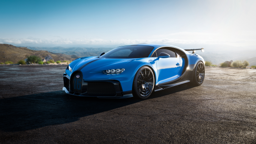

In [4]:
# Testing downloading
from fastdownload import download_url
dest = 'car.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'bike'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


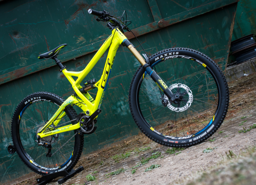

In [5]:
# The same for the other class
download_url(search_images('bike', max_images=1)[0], 'bike.jpg', show_progress=False)
Image.open('bike.jpg').to_thumb(256,256)

In [6]:
# Create training data
searches = 'bike','car'
path = Path('bike_or_car')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(5)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} model'))
    sleep(6)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(7)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'bike photo'
Searching for 'bike model'
Searching for 'bike'
Searching for 'car photo'
Searching for 'car model'
Searching for 'car'


In [7]:
# Checking for failed downloads
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

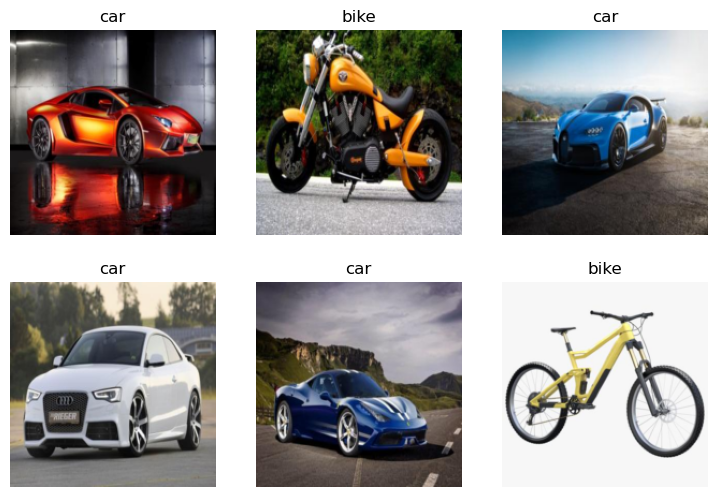

In [8]:
# Setting up DataBlock for training with fastai
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]    #originally trained with 256x256 images
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [9]:
# Training the model using existing architecture
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 60.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.984837,0.830123,0.294118,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.113745,0.111492,0.029412,00:02
1,0.081351,0.025305,0.029412,00:01
2,0.054885,0.009576,0.000000,00:01


In [10]:
# Testing trained model
label,_,probs = learn.predict(PILImage.create('car.jpg'))
print(f"This is a: {label}.")
print(f"Probability it's a car: {probs[1]:.4f}")

This is a: car.
Probability it's a car: 1.0000


In [11]:
# Creating a pickle file for the model
learn.export()

In [12]:
# Using the exported model to test prediction
learn = load_learner('export.pkl')

labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [13]:
# Setting up gradio
!pip install -Uqq gradio
import gradio as gr
#gr.Interface(fn=predict, inputs=gr.inputs.Image(shape=(512, 512)), outputs=gr.outputs.Label(num_top_classes=3)).launch(share=True)

In [14]:
# Setting up parameters for the gradio interface
title = "Bike or Car?"
description = "Simple demo to determine if an image contains a bike or a car."
examples = ['car.jpg', 'bike.jpg']
interpretation='default'

In [15]:
# Test run
gr.Interface(fn=predict,
             inputs=gr.inputs.Image(shape=(512, 512)),
             outputs=gr.outputs.Label(num_top_classes=2),
             title=title,
             description=description,
             examples=examples,
             interpretation=interpretation).launch(share=True)

/opt/conda/lib/python3.10/site-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/opt/conda/lib/python3.10/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://26d8ca371d538d33a9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [16]:
%%writefile app.py

import gradio as gr
from fastai.vision.all import *
import skimage

learn = load_learner('export.pkl')

labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "Bike or Car?"
description = "Simple demo to determine if an image contains a bike or a car."
examples = ['car.jpg', 'bike.jpg']
interpretation='default'

gr.Interface(fn=predict,
             inputs=gr.inputs.Image(shape=(512, 512)),
             outputs=gr.outputs.Label(num_top_classes=2),
             title=title,
             description=description,
             examples=examples,
             interpretation=interpretation).launch()

Writing app.py


In [17]:
%%writefile requirements.txt

fastai
gradio
scikit-image

Writing requirements.txt


Reference:
- https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data
- https://www.tanishq.ai/blog/gradio_hf_spaces_tutorial